In [23]:
# What this cell does: Imports all necessary libraries for the full pipeline.

import pandas as pd
import numpy as np
import xmltodict
from Evtx.Evtx import Evtx
import time
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import f1_score, mean_squared_error
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sentence_transformers import SentenceTransformer
from sklearn.utils import compute_class_weight
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

DEVICE = 'cpu' # Use 'cuda' if your local machine has a powerful GPU
print(f"Using device: {DEVICE}")

Using device: cpu


In [43]:
# What this cell does: Loads your Sysmon EVTX file, parses the raw data, and creates a checkpoint.
# Why it is needed: Converts binary log data to a DataFrame and saves a faster-loading checkpoint.

import os
import pandas as pd
import xmltodict
from Evtx.Evtx import Evtx

# --- 1. Define Local File Path ---
file_path_evtx = 'D:\\ML MAIN\\final_sysmon_data_export.evtx' # UPDATE THIS PATH/FILENAME
checkpoint_file = 'parsed_raw_data_checkpoint.csv'

# Check if the file exists locally
if not os.path.exists(file_path_evtx):
    raise FileNotFoundError(f"Error: Log file not found at '{file_path_evtx}'. Please check the path.")

# --- 2. Define Parsing Function ---
def parse_evtx(file_path):
    """Parses the EVTX file, extracting the nested XML data into a DataFrame."""
    logs = []
    with Evtx(file_path) as log:
        for record in log.records():
            try:
                # Use xmltodict to convert raw XML string into a Python dictionary
                data = xmltodict.parse(record.xml())["Event"]
                logs.append(data)
            except:
                continue
    return pd.DataFrame(logs)

# --- 3. Execute Loading and Checkpoint ---

# Check if the fast-loading checkpoint file already exists
if os.path.exists(checkpoint_file):
    print(f"Loading data from fast checkpoint: {checkpoint_file}")
    df_raw = pd.read_csv(checkpoint_file)
else:
    # If checkpoint doesn't exist, run the slow parsing process
    print(f"Checkpoint not found. Running slow EVTX parsing for {file_path_evtx}...")
    df_raw = parse_evtx(file_path_evtx)
    
    # Save the checkpoint (Note: We save raw data, final cleaning is done in CELL 3)
    try:
        # Saving a large, raw file might be slow and complex due to nested data, but it acts as a marker.
        # It's highly recommended to save the final, flattened data after CELL 3 instead.
        df_raw.to_csv(checkpoint_file, index=False) 
        print(f"Raw data saved to checkpoint: {checkpoint_file}")
    except Exception as e:
        print(f"Warning: Could not save raw data to CSV checkpoint. Proceeding.")


print(f"\nTotal raw events parsed: {len(df_raw)}.")

Checkpoint not found. Running slow EVTX parsing for D:\ML MAIN\final_sysmon_data_export.evtx...
Raw data saved to checkpoint: parsed_raw_data_checkpoint.csv

Total raw events parsed: 25811.


In [35]:
# What this cell does: Extracts critical features (CommandLine, Image, ParentImage, EventID)
# from the nested log structure and cleans them.

def extract_and_flatten_fields(df):
    """Flattens nested log data and extracts relevant Sysmon fields."""
    flat_rows = []
    for _, r in df.iterrows():
        flat = {}
        system = r.get('System', {}); flat["EventID"] = system.get('EventID', {}).get('#text', '0')
        event_data = r.get('EventData', {}); data_items = event_data.get('Data', [])
        
        if isinstance(data_items, dict): data_items = [data_items]
        data_dict = {item.get('@Name', 'Unknown'): item.get('#text', 'Unknown') for item in data_items}

        flat['CommandLine'] = data_dict.get('CommandLine', '')
        flat['Image'] = data_dict.get('Image', '')
        flat['ParentImage'] = data_dict.get('ParentImage', '')
        flat_rows.append(flat)

    return pd.DataFrame(flat_rows)

logs_df = extract_and_flatten_fields(df_raw)
logs_df[['CommandLine', 'Image', 'ParentImage']] = logs_df[['CommandLine', 'Image', 'ParentImage']].fillna('')

print("Log data flattened and cleaned.")

Log data flattened and cleaned.


In [36]:
# What this cell does: Labels events with MITRE Tactics (y) and builds the contextual text input (X feature).

# --- 1. Labeling Configuration (MITRE Tactic Mapping) ---
EVENT_ID_TO_TACTIC = {'1': 'Execution', '3': 'Command and Control', '7': 'Defense Evasion', '11': 'Persistence', '22': 'Discovery'}
KEYWORD_TO_TACTIC = {'mimikatz': 'Credential Access', 'psexec': 'Lateral Movement', 'whoami': 'Discovery', 'schtasks': 'Persistence'}

def apply_mitre_label(row):
    command_line = row['CommandLine'].lower()
    for kw, tactic in KEYWORD_TO_TACTIC.items():
        if kw in command_line: return tactic
    
    event_id_str = str(row['EventID'])
    if event_id_str in EVENT_ID_TO_TACTIC: return EVENT_ID_TO_TACTIC[event_id_str]
    return 'benign'

logs_df['tactic_label'] = logs_df.apply(apply_mitre_label, axis=1)

# --- 2. Contextual Text Construction ---
def build_context_text(row):
    """Combines key fields into a single text string for the Transformer."""
    return (
        f"EventID:{row['EventID']} | "
        f"Image:{row['Image']} | "
        f"Parent:{row['ParentImage']} | "
        f"Cmd:{row['CommandLine']}"
    )

logs_df['context_text'] = logs_df.apply(build_context_text, axis=1)
print("Tactic labels and Contextual Text created.")

Tactic labels and Contextual Text created.


In [37]:
# What this cell does: Generates the high-dimensional input data (embeddings, X) and scales it.
# Why it is needed: Creates the "CTI event embeddings" which is the input to the DR (Step 1).

# --- 1. Generate Embeddings ---
model_name = 'all-MiniLM-L6-v2' 
embedding_model = SentenceTransformer(model_name)
embedding_model.to(DEVICE)

print(f"Generating embeddings using {model_name}...")
embeddings = embedding_model.encode(
    logs_df['context_text'].tolist(), 
    batch_size=128, 
    show_progress_bar=True,
    convert_to_numpy=True
)

# --- 2. Encode Labels and Scale Data ---
X_full = embeddings
y_full = logs_df['tactic_label']

le = LabelEncoder()
y_encoded = le.fit_transform(y_full)
CLASS_NAMES = le.classes_ 

# Scale the embeddings (CRITICAL for Autoencoders and LDA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_full)
INPUT_DIM = X_scaled.shape[1]

print(f"Original Embedding Shape (X_scaled): {X_scaled.shape}")
print("Embeddings generated and scaled.")

Generating embeddings using all-MiniLM-L6-v2...


Batches: 100%|██████████| 202/202 [01:40<00:00,  2.02it/s]


Original Embedding Shape (X_scaled): (25811, 384)
Embeddings generated and scaled.


In [38]:
# What this cell does: Defines DR parameters, calculates class weights, and prepares data subsets for comparison.

REDUCTION_VARIANTS = [2, 10, 50] 
INPUT_DIM = X_scaled.shape[1] 

# Determine maximum feasible LDA components (n_classes - 1)
n_classes = len(CLASS_NAMES)
n_max_components = min(n_classes - 1, INPUT_DIM)

# Split the full dataset for the Downstream Task Evaluation (Step 5)
X_train_full, X_test_full, y_train_full, y_test_full = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42
)

# Calculate Class Weights once (needed for Downstream Classification Evaluation)
weights = compute_class_weight(
    class_weight='balanced', 
    classes=np.unique(y_train_full), 
    y=y_train_full
)
CLASS_WEIGHT_DICT = dict(zip(np.unique(y_train_full), weights))

print(f"Maximum effective LDA components: {n_max_components}")
print("DR setup and data splitting complete.")

Maximum effective LDA components: 4
DR setup and data splitting complete.


In [39]:
# What this cell does: Applies supervised LDA for reduction and calculates Variance Explained (Deliverable).

lda_results = {}
print("--- Applying LDA (Supervised, Linear Reduction) ---")

for k in REDUCTION_VARIANTS:
    if k > n_max_components:
        print(f"Skipping LDA to {k}D.")
        continue

    lda = LinearDiscriminantAnalysis(n_components=k)
    X_lda = lda.fit_transform(X_scaled, y_encoded)
    
    explained_variance_ratio_sum = np.sum(lda.explained_variance_ratio_) 

    lda_results[k] = {'X_reduced': X_lda, 'variance_explained': explained_variance_ratio_sum}
    print(f"LDA reduced data to {k}D. Variance Explained: {explained_variance_ratio_sum:.4f}")

--- Applying LDA (Supervised, Linear Reduction) ---
LDA reduced data to 2D. Variance Explained: 0.9221
Skipping LDA to 10D.
Skipping LDA to 50D.


In [40]:
# What this cell does: Defines, trains, and applies the Autoencoder (AE) for non-linear reduction.
# Why it is needed: Fulfills Step 1 (Apply AE) and calculates Reconstruction Error (Step 3).

# --- 1. Define Autoencoder Model ---
EPOCHS = 20; BATCH_SIZE = 32

class Autoencoder(nn.Module):
    def __init__(self, input_dim, latent_dim):
        super().__init__();
        self.encoder = nn.Sequential(nn.Linear(input_dim, 100), nn.ReLU(), nn.Linear(100, latent_dim));
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 100), nn.ReLU(), nn.Linear(100, input_dim));
    def forward(self, x):
        encoded = self.encoder(x); decoded = self.decoder(encoded); return decoded, encoded

def train_ae(model, X_tensor, epochs):
    criterion = nn.MSELoss(); optimizer = optim.Adam(model.parameters(), lr=1e-3);
    data_loader = DataLoader(TensorDataset(X_tensor), batch_size=BATCH_SIZE, shuffle=True);
    model.train()
    for epoch in range(epochs):
        for data in data_loader:
            x = data[0].to(DEVICE); reconstructed, _ = model(x); loss = criterion(reconstructed, x)
            optimizer.zero_grad(); loss.backward(); optimizer.step()
    return model

# --- 2. Apply AE for different dimensions ---
ae_results = {}; X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(DEVICE)
print("\n--- Applying Autoencoder Reduction ---")
for k in REDUCTION_VARIANTS:
    model = Autoencoder(INPUT_DIM, k).to(DEVICE); trained_model = train_ae(model, X_scaled_tensor, EPOCHS)
    
    with torch.no_grad(): reconstructed, X_ae = trained_model(X_scaled_tensor)
        
    reconstruction_error = mean_squared_error(X_scaled, reconstructed.cpu().numpy()) # Reconstruction Error (Step 3)
    
    ae_results[k] = {'X_reduced': X_ae.cpu().numpy(), 'reconstruction_error': reconstruction_error}
    print(f"AE reduced data to {k}D. Reconstruction Error: {reconstruction_error:.6f}")


--- Applying Autoencoder Reduction ---
AE reduced data to 2D. Reconstruction Error: 0.149846
AE reduced data to 10D. Reconstruction Error: 0.047513
AE reduced data to 50D. Reconstruction Error: 0.027954


In [41]:
# What this cell does: Measures the preservation of predictive structure (Macro F1 Score) (Step 5).

results_table = []
def evaluate_downstream(X_train, X_test, y_train, y_test, method_name, k):
    """Trains a Logistic Regression classifier on reduced features."""
    clf = LogisticRegression(max_iter=1000, multi_class='multinomial', random_state=42, class_weight=CLASS_WEIGHT_DICT)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=0)
    results_table.append({'Method': method_name, 'Dimension': k, 'Macro_F1_Score': f1})
    print(f"  {method_name} ({k}D): F1 Score = {f1:.4f}")

print("\n--- Starting Downstream Classifier Evaluation ---")
# 1. Baseline
evaluate_downstream(X_train_full, X_test_full, y_train_full, y_test_full, 'Original Embedding', INPUT_DIM)

# 2. LDA Variants
for k in lda_results:
    X_reduced = lda_results[k]['X_reduced']
    X_train_red, X_test_red, _, _ = train_test_split(X_reduced, y_encoded, test_size=0.2, random_state=42)
    evaluate_downstream(X_train_red, X_test_red, y_train_full, y_test_full, 'LDA (Linear)', k)

# 3. Autoencoder Variants
for k in ae_results:
    X_reduced = ae_results[k]['X_reduced']
    X_train_red, X_test_red, _, _ = train_test_split(X_reduced, y_encoded, test_size=0.2, random_state=42)
    evaluate_downstream(X_train_red, X_test_red, y_train_full, y_test_full, 'Autoencoder (Non-Linear)', k)


--- Starting Downstream Classifier Evaluation ---


d:\TIME\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Original Embedding (384D): F1 Score = 0.9985


d:\TIME\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  LDA (Linear) (2D): F1 Score = 0.9558
  Autoencoder (Non-Linear) (2D): F1 Score = 0.5136


d:\TIME\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
d:\TIME\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Autoencoder (Non-Linear) (10D): F1 Score = 0.7691


d:\TIME\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.8. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


  Autoencoder (Non-Linear) (50D): F1 Score = 0.9897



--- Final Dimensionality Reduction Metrics Table (Deliverable) ---
                     Method  Dimension  Macro_F1_Score Variance_Explained (LDA) Reconstruction_Error (AE)
0        Original Embedding        384        0.998480                      1.0                       0.0
1  Autoencoder (Non-Linear)         50        0.989707                      N/A                  0.027954
2              LDA (Linear)          2        0.955802                 0.922109                       N/A
3  Autoencoder (Non-Linear)         10        0.769136                      N/A                  0.047513
4  Autoencoder (Non-Linear)          2        0.513580                      N/A                  0.149846
Final metrics table saved as final_dr_metrics_table.csv.


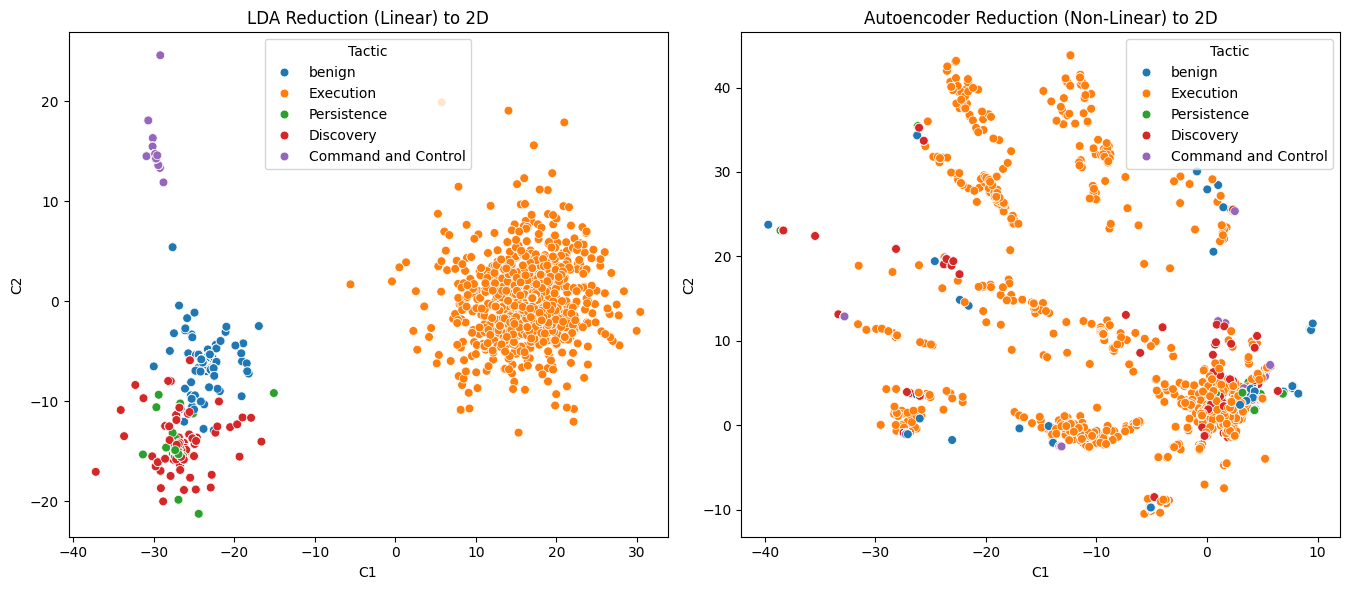

In [42]:
# What this cell does: Generates the 2D plots and compiles the final deliverables table.

# --- 1. Compile Final Metrics Table (Deliverable) ---
df_results = pd.DataFrame(results_table).sort_values(by=['Macro_F1_Score', 'Dimension'], ascending=[False, True])

final_metrics = []
for index, row in df_results.iterrows():
    k = row['Dimension']
    var_exp = lda_results[k]['variance_explained'] if row['Method'] == 'LDA (Linear)' else ('N/A' if row['Method'] != 'Original Embedding' else 1.0)
    rec_err = ae_results[k]['reconstruction_error'] if row['Method'] == 'Autoencoder (Non-Linear)' else ('N/A' if row['Method'] != 'Original Embedding' else 0.0)
    
    final_metrics.append({
        'Method': row['Method'],
        'Dimension': k,
        'Macro_F1_Score': row['Macro_F1_Score'],
        'Variance_Explained (LDA)': var_exp,
        'Reconstruction_Error (AE)': rec_err,
    })

df_final_metrics = pd.DataFrame(final_metrics)

print("\n--- Final Dimensionality Reduction Metrics Table (Deliverable) ---")
print(df_final_metrics.to_string())
df_final_metrics.to_csv('final_dr_metrics_table.csv', index=False)
print("Final metrics table saved as final_dr_metrics_table.csv.")


# --- 2. Visualization (2D Plot) ---
X_lda_2d = lda_results.get(2, {}).get('X_reduced')
X_ae_2d = ae_results.get(2, {}).get('X_reduced')

plt.figure(figsize=(16, 6))

if X_lda_2d is not None and X_ae_2d is not None:
    # LDA 2D Plot (Maximize Separation)
    plt.subplot(1, 2, 1)
    df_lda_2d = pd.DataFrame({'C1': X_lda_2d[:, 0], 'C2': X_lda_2d[:, 1], 'Tactic': y_full})
    sns.scatterplot(data=df_lda_2d, x='C1', y='C2', hue='Tactic', palette='tab10', legend='full', s=40)
    plt.title('LDA Reduction (Linear) to 2D')

    # Autoencoder 2D Plot (Minimize Reconstruction Loss)
    plt.subplot(1, 2, 2)
    df_ae_2d = pd.DataFrame({'C1': X_ae_2d[:, 0], 'C2': X_ae_2d[:, 1], 'Tactic': y_full})
    sns.scatterplot(data=df_ae_2d, x='C1', y='C2', hue='Tactic', palette='tab10', legend='full', s=40)
    plt.title('Autoencoder Reduction (Non-Linear) to 2D')

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('2d_reduction_comparison.png')
plt.show()